In [23]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Load both images
roi_img = io.imread('ch00-1_new.png')
dapi_rgb = io.imread('PVN, MD, RE image61_R 91_Merged_ch00_SV.tif')
dapi = dapi_rgb[..., 2]  # Blue channel

print("ROI annotation shape:", roi_img.shape)
print("DAPI shape:", dapi.shape)
print("Match:", roi_img.shape[:2] == dapi.shape[:2])

ROI annotation shape: (471, 382, 3)
DAPI shape: (4713, 3817)
Match: False


In [24]:
# Extract pure color regions (saturated RGB)
# Threshold: high in target channel, low in others

r, g, b = roi_img[..., 0], roi_img[..., 1], roi_img[..., 2]

# Adjust threshold if needed - 200 for "high", 100 for "low"
high, low = 200, 100

mask_red = (r > high) & (g < low) & (b < low)
mask_green = (g > high) & (r < low) & (b < low)
mask_blue = (b > high) & (r < low) & (g < low)

print(f"Red region:   {mask_red.sum():,} pixels")
print(f"Green region: {mask_green.sum():,} pixels")
print(f"Blue region:  {mask_blue.sum():,} pixels")

Red region:   12,012 pixels
Green region: 6,791 pixels
Blue region:  15,763 pixels


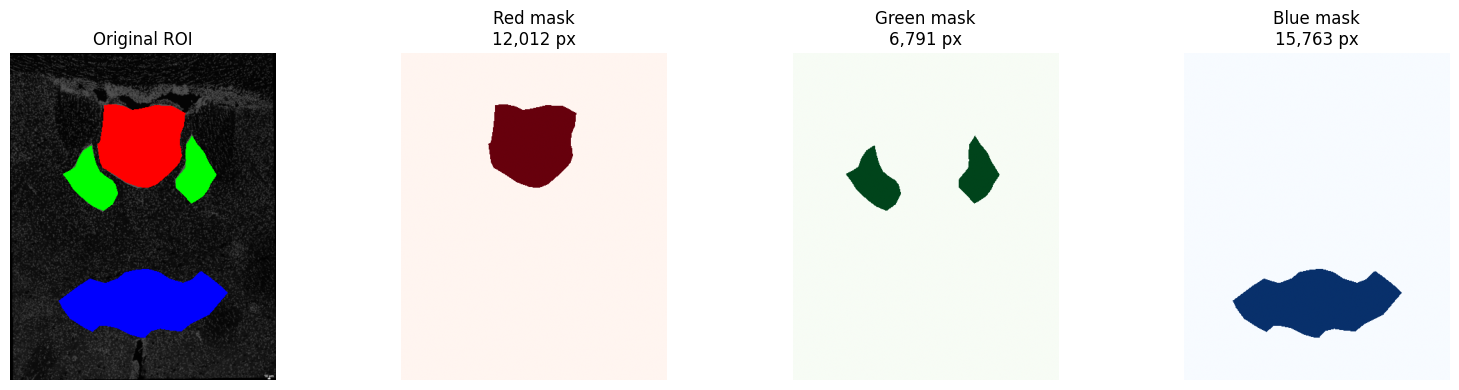

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(roi_img)
axes[0].set_title('Original ROI')

axes[1].imshow(mask_red, cmap='Reds')
axes[1].set_title(f'Red mask\n{mask_red.sum():,} px')

axes[2].imshow(mask_green, cmap='Greens')
axes[2].set_title(f'Green mask\n{mask_green.sum():,} px')

axes[3].imshow(mask_blue, cmap='Blues')
axes[3].set_title(f'Blue mask\n{mask_blue.sum():,} px')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd

# Calculate scale factors
scale_y = roi_img.shape[0] / dapi.shape[0]
scale_x = roi_img.shape[1] / dapi.shape[1]

print(f"Scale factors: y={scale_y:.4f}, x={scale_x:.4f}")
print(f"Aspect ratio match: {abs(scale_y - scale_x) < 0.01}")  # Check if uniform scaling

# Assign cells to regions using scaled coordinates
def assign_region_scaled(row):
    # Convert DAPI coords to ROI coords
    y_roi = int(row['y'] * scale_y)
    x_roi = int(row['x'] * scale_x)
    
    # Bounds check
    if 0 <= y_roi < roi_img.shape[0] and 0 <= x_roi < roi_img.shape[1]:
        if mask_red[y_roi, x_roi]: return 'red'
        if mask_green[y_roi, x_roi]: return 'green'
        if mask_blue[y_roi, x_roi]: return 'blue'
    return 'outside'


df = pd.read_csv('pvn_cell_analysis.csv')

df['region'] = df.apply(assign_region_scaled, axis=1)
print("\nCells per region:")
print(df['region'].value_counts())

Scale factors: y=0.0999, x=0.1001
Aspect ratio match: True

Cells per region:
region
outside    19862
blue        2295
red         1632
green        923
Name: count, dtype: int64


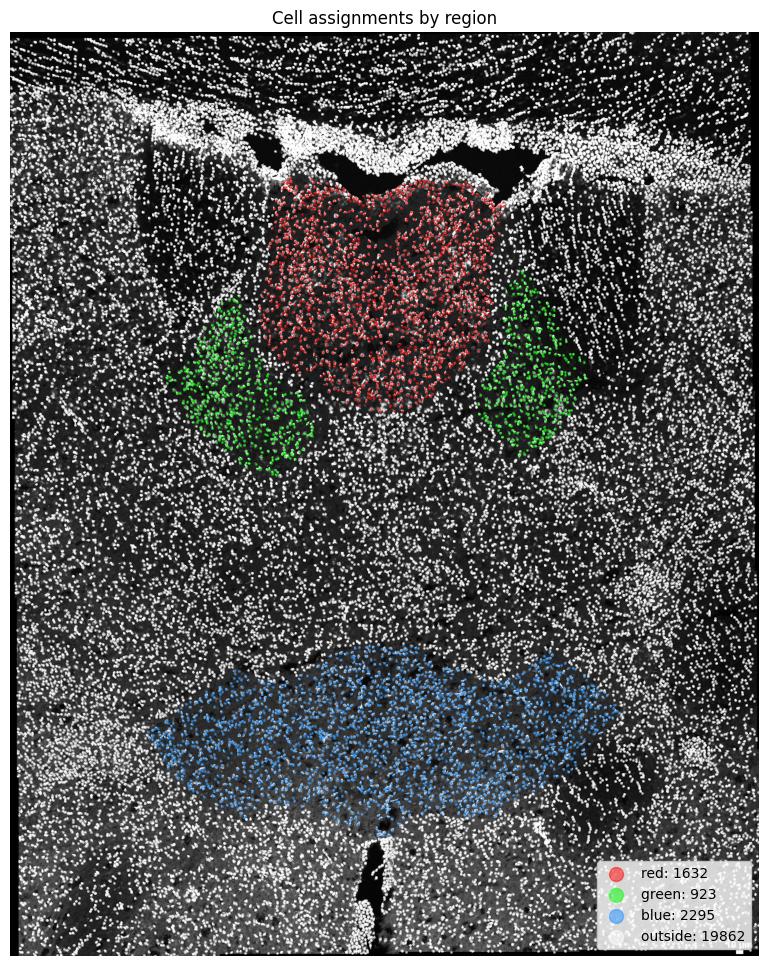

In [27]:
# Plot cell centroids colored by assigned region on DAPI
plt.figure(figsize=(12, 12))

p2, p98 = np.percentile(dapi, (2, 98))
plt.imshow(dapi, cmap='gray', vmin=p2, vmax=p98)

colors = {'red': 'red', 'green': 'lime', 'blue': 'dodgerblue', 'outside': 'white'}
for region, color in colors.items():
    subset = df[df['region'] == region]
    plt.scatter(subset['x'], subset['y'], c=color, s=1, alpha=0.5, label=f'{region}: {len(subset)}')

plt.legend(markerscale=10)
plt.title('Cell assignments by region')
plt.axis('off')
plt.show()

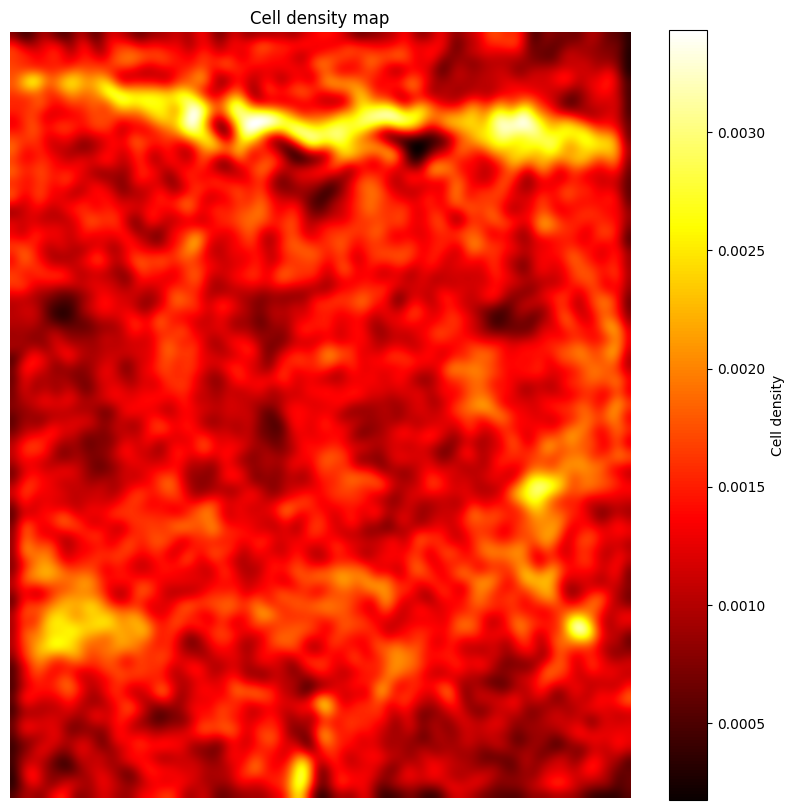

In [6]:
from scipy.ndimage import gaussian_filter

# Create density map from cell centroids
density_map = np.zeros(dapi.shape, dtype=float)
for _, row in df.iterrows():
    y, x = int(row['y']), int(row['x'])
    if 0 <= y < dapi.shape[0] and 0 <= x < dapi.shape[1]:
        density_map[y, x] = 1

# Smooth to get density
density_smooth = gaussian_filter(density_map, sigma=50)

plt.figure(figsize=(10, 10))
plt.imshow(density_smooth, cmap='hot')
plt.colorbar(label='Cell density')
plt.title('Cell density map')
plt.axis('off')
plt.show()

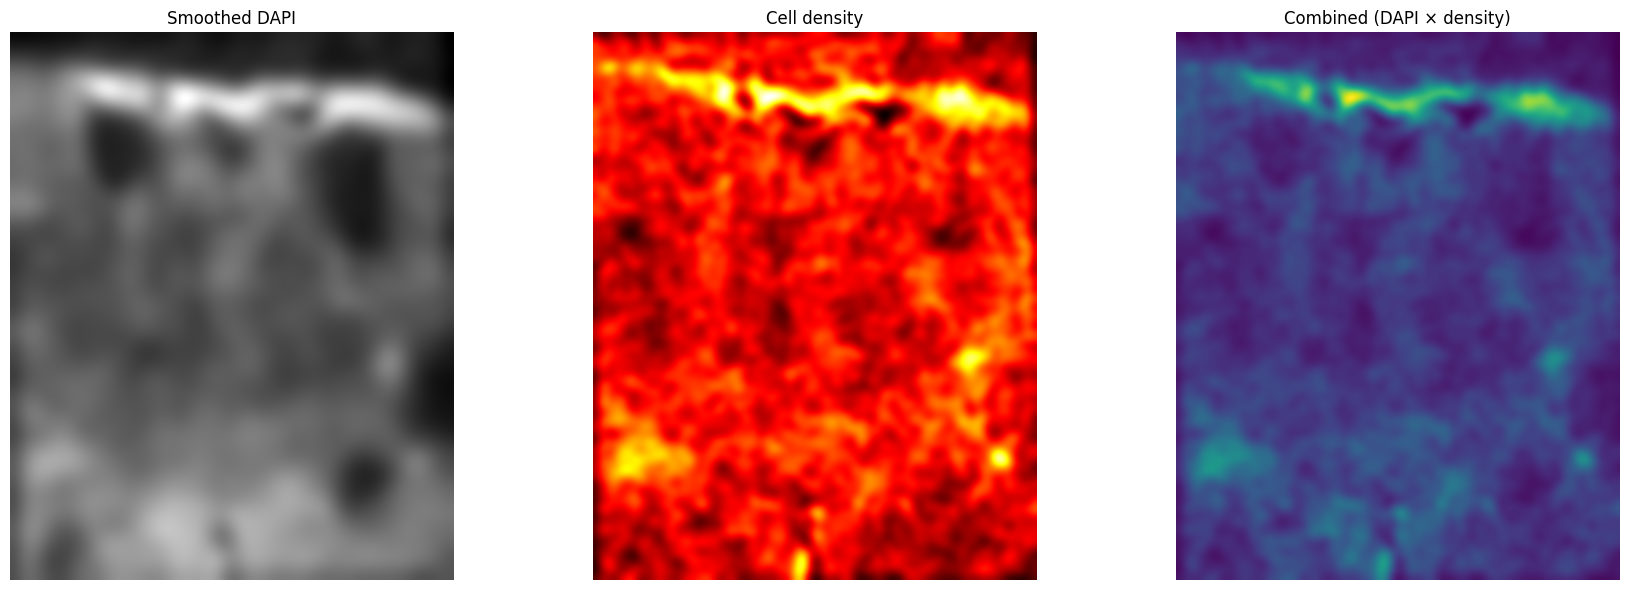

In [7]:
# Smooth DAPI to see regional intensity differences
dapi_smooth = gaussian_filter(dapi.astype(float), sigma=100)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(dapi_smooth, cmap='gray')
axes[0].set_title('Smoothed DAPI')

axes[1].imshow(density_smooth, cmap='hot')
axes[1].set_title('Cell density')

# Combine: intensity * density
combined = dapi_smooth * density_smooth
combined = combined / combined.max()
axes[2].imshow(combined, cmap='viridis')
axes[2].set_title('Combined (DAPI × density)')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.cluster import KMeans

# Create feature image for clustering
# Stack density and intensity as features
features = np.stack([
    density_smooth / density_smooth.max(),
    dapi_smooth / dapi_smooth.max()
], axis=-1)

# Only cluster where there are cells (mask out sparse areas)
cell_mask = density_smooth > density_smooth.max() * 0.05

# Reshape for clustering
h, w = dapi.shape
coords = np.array([(y, x) for y in range(h) for x in range(w) if cell_mask[y, x]])
feat_vals = features[cell_mask]

# Add spatial coordinates as weak features
coords_norm = coords / np.array([h, w])
feat_with_space = np.hstack([feat_vals, coords_norm * 0.5])  # 0.5 = spatial weight

print(f"Clustering {len(coords)} pixels...")
kmeans = KMeans(n_clusters=50, random_state=42, n_init=100)
labels = kmeans.fit_predict(feat_with_space)

# Reconstruct label image
label_img = np.zeros((h, w), dtype=int) - 1
label_img[cell_mask] = labels

plt.figure(figsize=(12, 12))
plt.imshow(label_img, cmap='tab10', vmin=0)
plt.title('K-means clustering (4 regions)')
plt.colorbar()
plt.axis('off')
plt.show()

KeyboardInterrupt: 

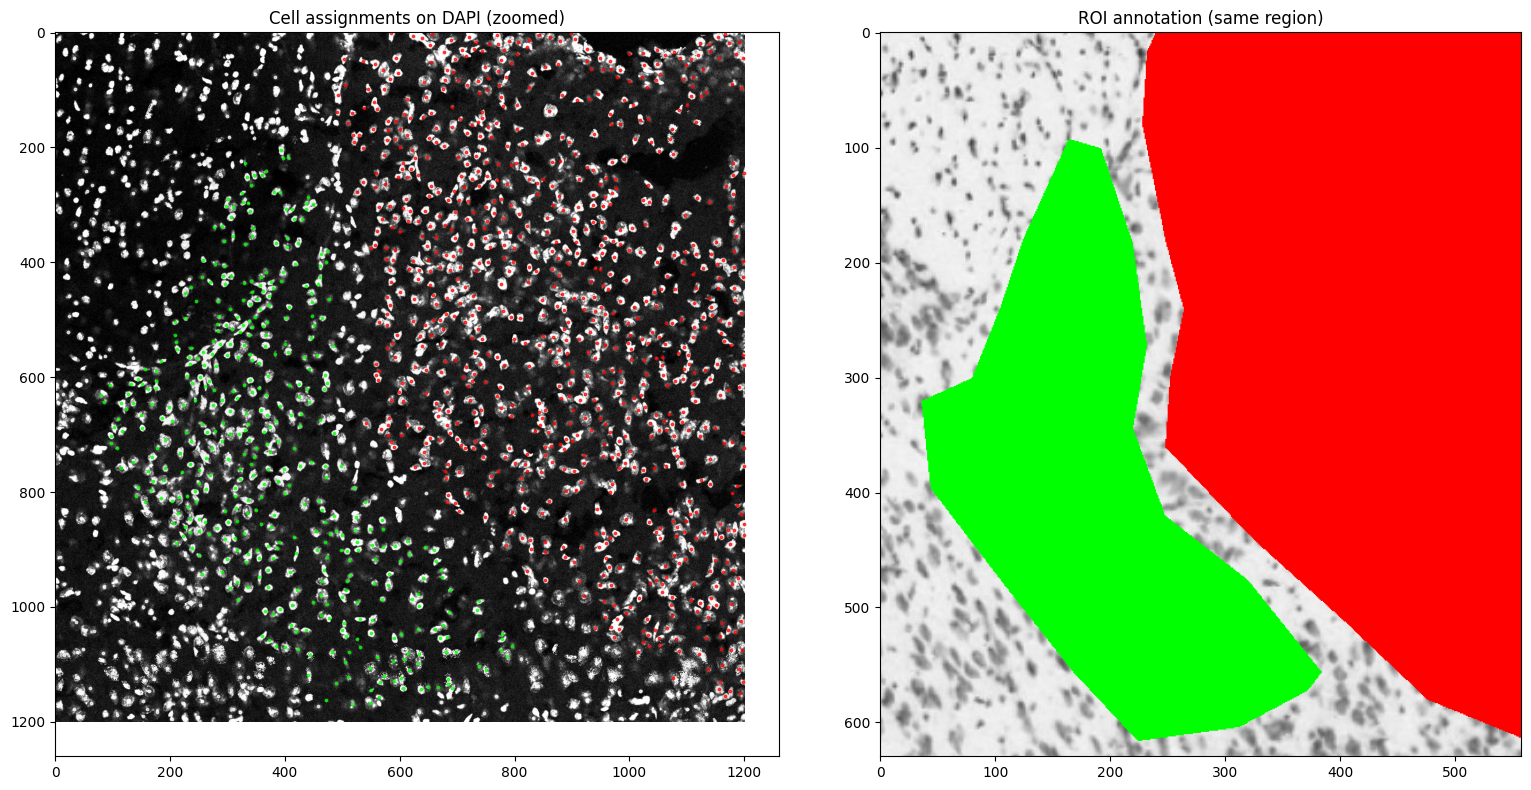

In [9]:
# Show a zoomed region where we can see individual cells and their assignments
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pick a region with all three colors nearby (looks like upper-middle area)
# Adjust these bounds to focus on the interface between regions
y_slice = slice(800, 2000)
x_slice = slice(800, 2000)

# Left: DAPI with cell assignments
p2, p98 = np.percentile(dapi[y_slice, x_slice], (2, 98))
axes[0].imshow(dapi[y_slice, x_slice], cmap='gray', vmin=p2, vmax=p98)

colors = {'red': 'red', 'green': 'lime', 'blue': 'cyan', 'outside': 'white'}
for region, color in colors.items():
    subset = df[(df['region'] == region) & 
                (df['y'] > y_slice.start) & (df['y'] < y_slice.stop) &
                (df['x'] > x_slice.start) & (df['x'] < x_slice.stop)]
    axes[0].scatter(subset['x'] - x_slice.start, subset['y'] - y_slice.start, 
                    c=color, s=3, alpha=0.7)
axes[0].set_title('Cell assignments on DAPI (zoomed)')

# Right: ROI annotation for same region (scaled)
y_roi_slice = slice(int(y_slice.start * scale_y), int(y_slice.stop * scale_y))
x_roi_slice = slice(int(x_slice.start * scale_x), int(x_slice.stop * scale_x))
axes[1].imshow(roi_img[y_roi_slice, x_roi_slice])
axes[1].set_title('ROI annotation (same region)')

plt.tight_layout()
plt.show()